# Neural networks for binary classification: Diabetes diagnosis

In [69]:
# Set random seeds for reproducible results
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import os

# Data processing and visualization
import numpy as np                           # Numerical computing
import pandas as pd                          # Data manipulation
from sklearn.model_selection import train_test_split  # Split data into train/test
from sklearn.preprocessing import MinMaxScaler    # Scale features (normalize values)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score  # Evaluation metrics

# Deep learning
from tensorflow.keras import models, layers  # Build neural network
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from tensorflow.keras.callbacks import EarlyStopping  # Stop training when validation loss plateaus

# Visualization
import matplotlib.pyplot as plt              # Plot training curves and results
import seaborn as sns                        # Enhanced visualizations

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Load pima diabetes dataset

In [39]:
data = pd.read_csv('./diabetes.csv')

print(data.shape)

data.head()

(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Statistics about the data

In [40]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [41]:
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


# Visualization

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

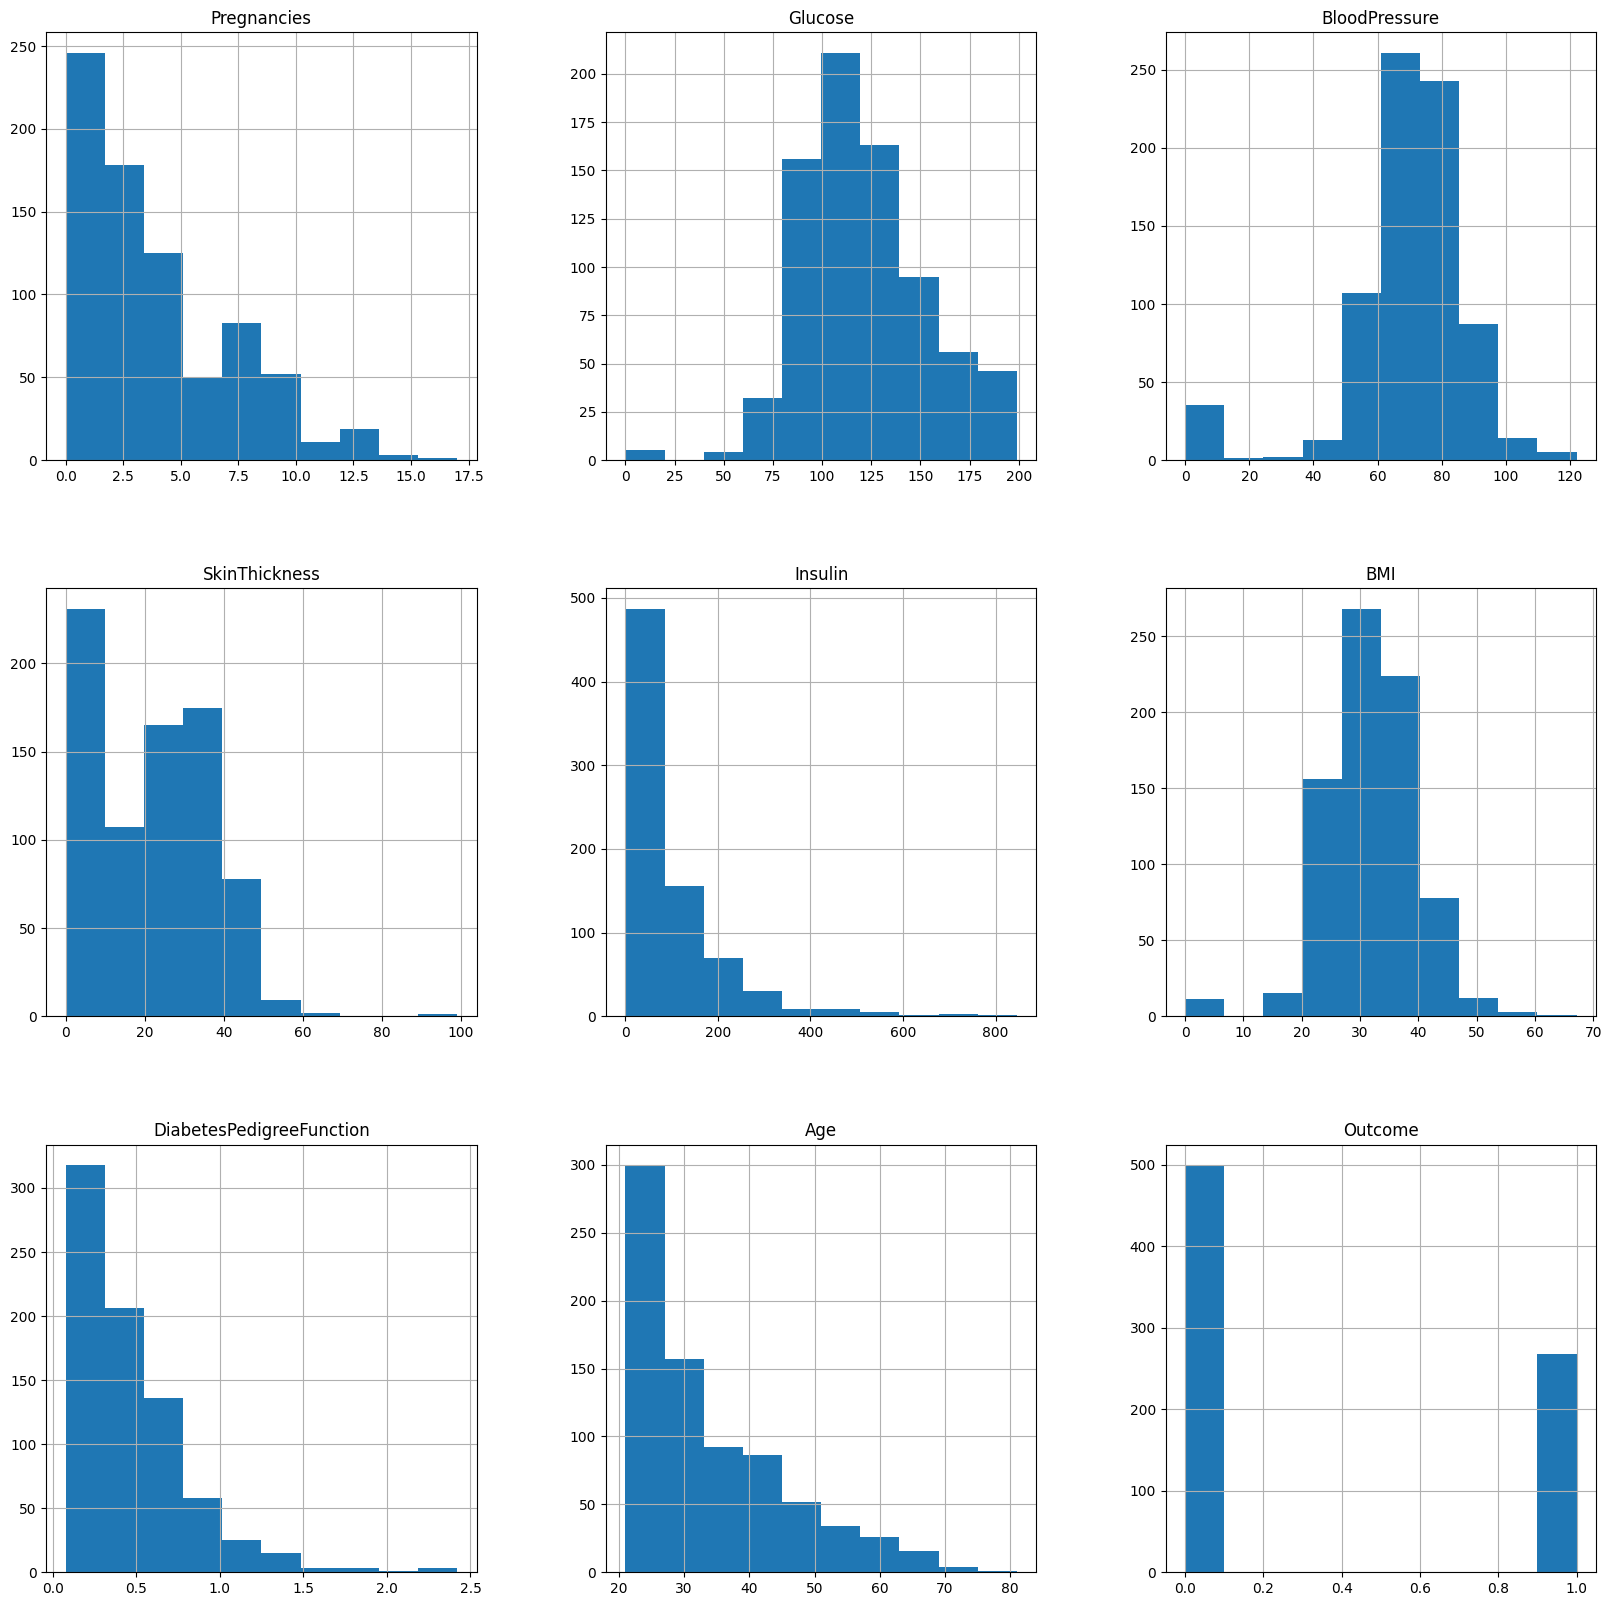

In [42]:
data.hist(figsize=(20,20))

## There are some columns of the dataset that have zeros which is an error.
## Glucose, BloodPressure, SkinThickness, Insulin, and BMI these columns should not have zeros

# Replacing these zeros with the mean

Zeros before: {'Glucose': 5, 'BloodPressure': 35, 'SkinThickness': 227, 'Insulin': 374, 'BMI': 11}
Zeros after:  {'Glucose': 0, 'BloodPressure': 0, 'SkinThickness': 0, 'Insulin': 0, 'BMI': 0}


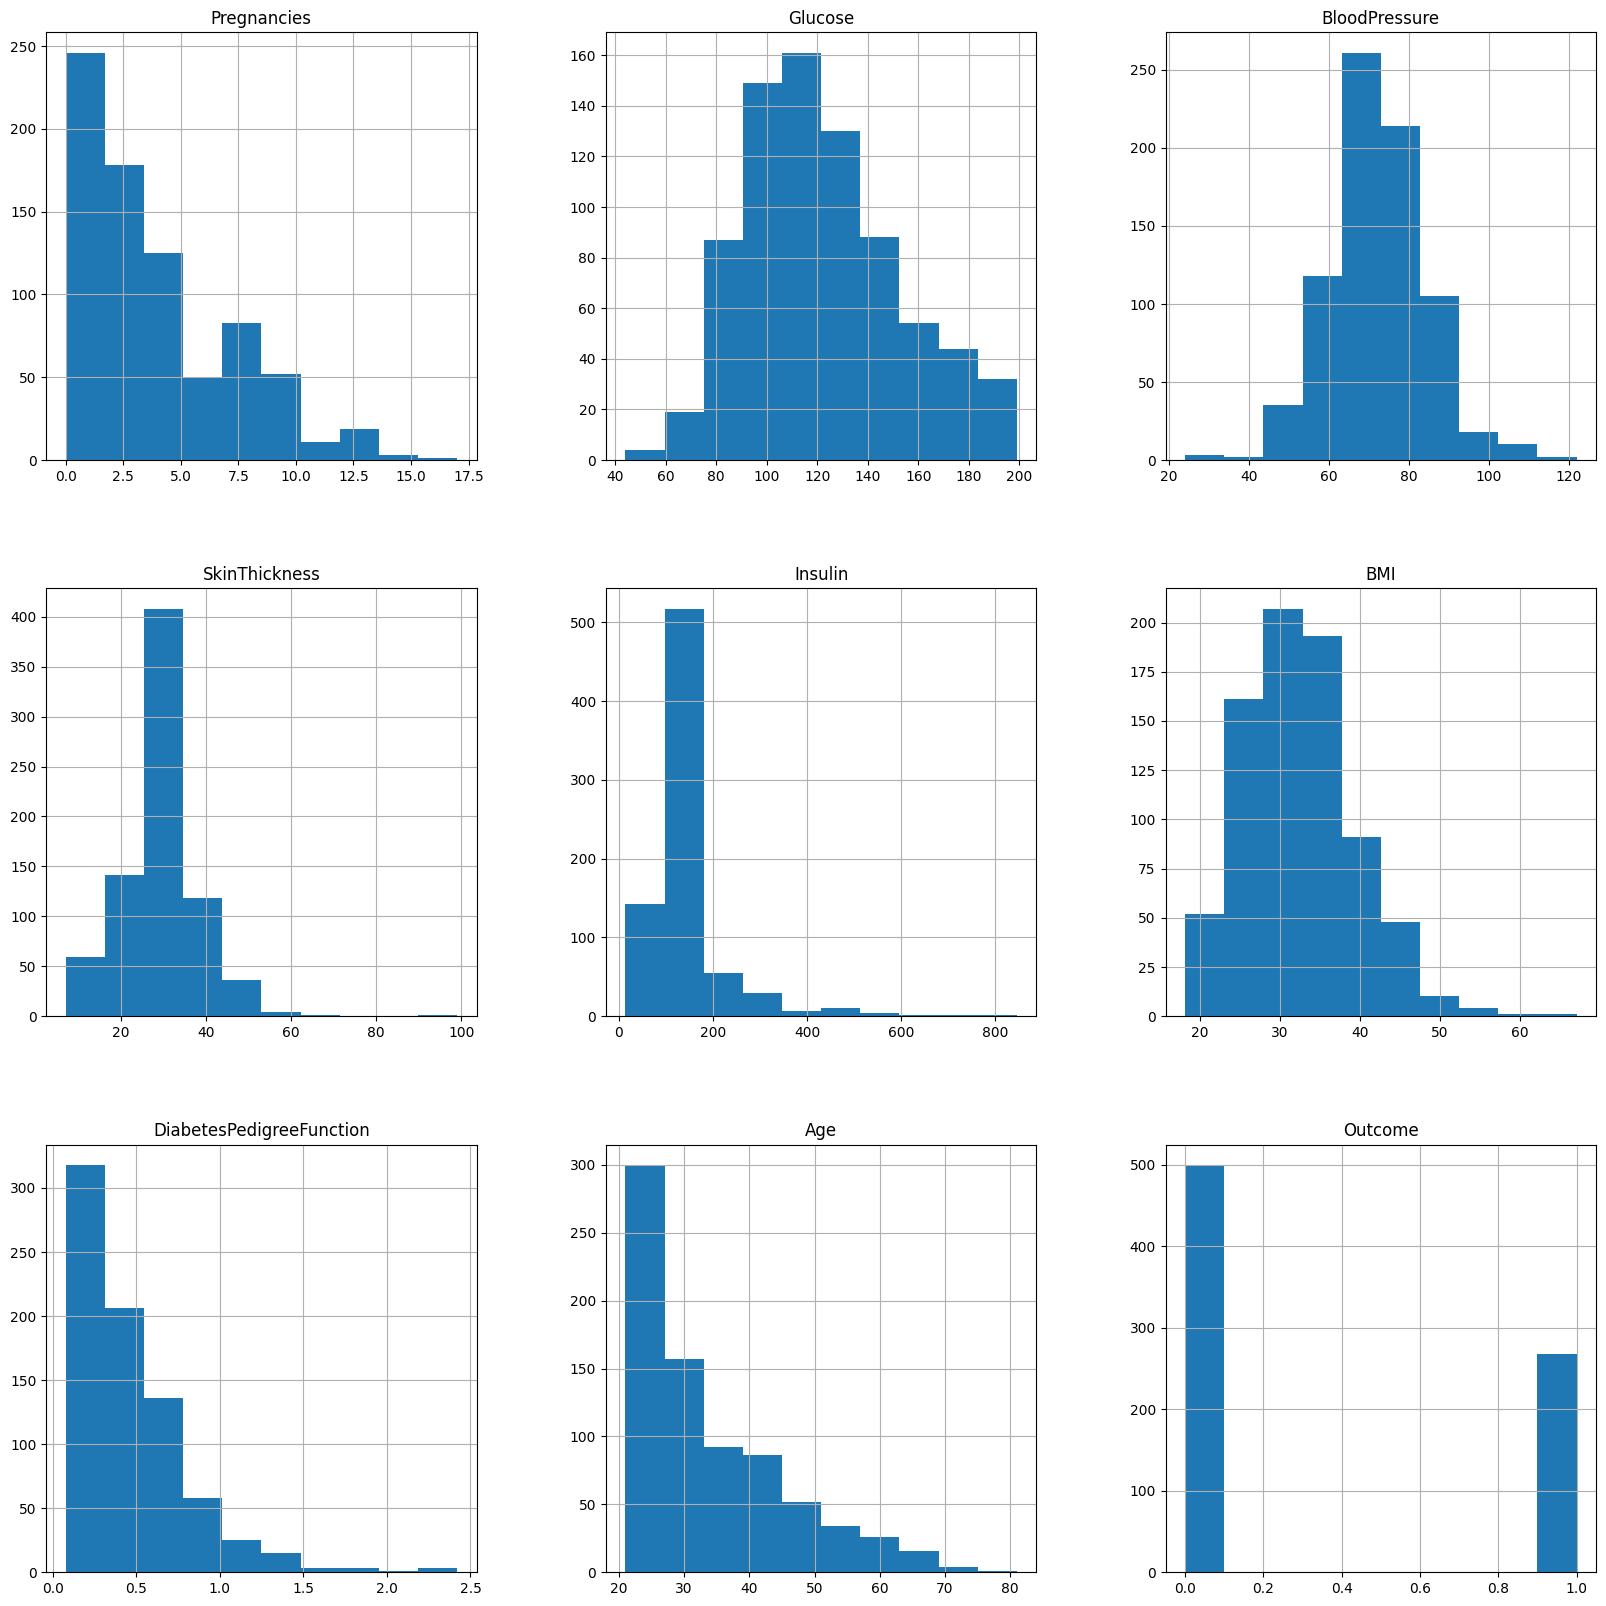

In [43]:
cols_to_fix = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

# replace 0 with NaN then fill with the mean computed excluding zeros
data_copy = data.copy(deep=True)
data_copy[cols_to_fix] = data_copy[cols_to_fix].replace(0, np.nan)
data_copy[cols_to_fix] = data_copy[cols_to_fix].apply(lambda col: col.fillna(col.mean()))

print('Zeros before:', (data[cols_to_fix] == 0).sum().to_dict())
print('Zeros after: ', (data_copy[cols_to_fix] == 0).sum().to_dict())

data_copy.hist(figsize=(20,20))
plt.show()

# Normalization

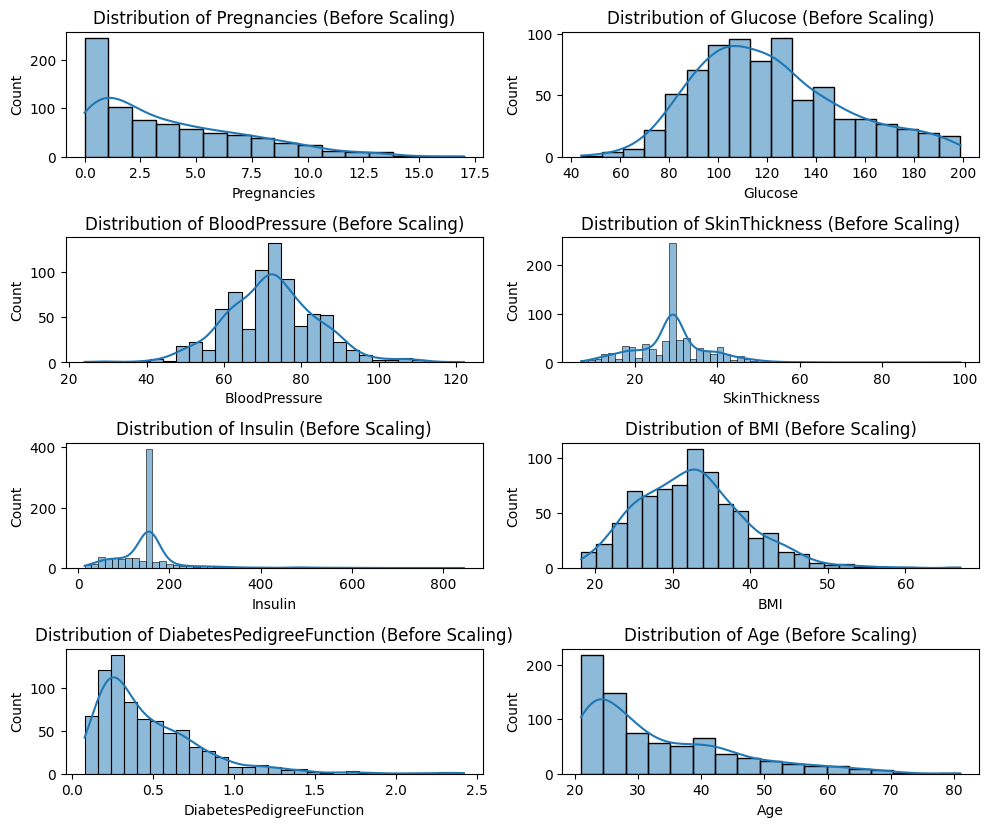

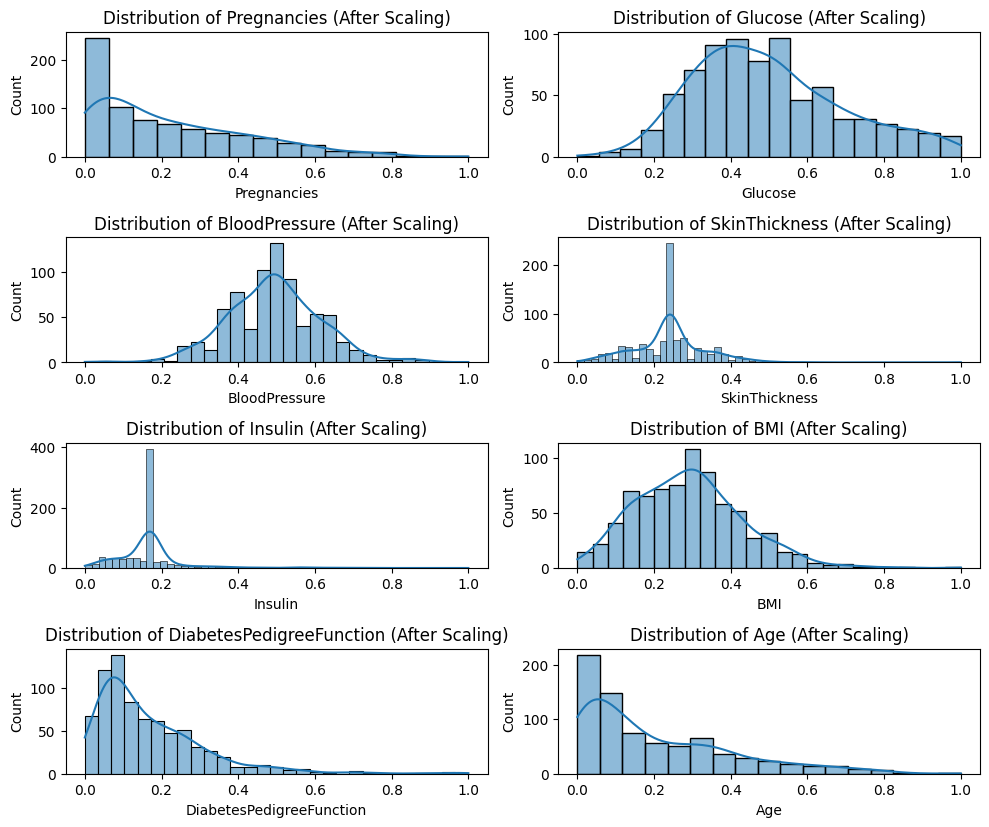

In [54]:
x_data = data_copy.iloc[:,:8]
y_label = data_copy['Outcome']

numeric_cols = x_data.select_dtypes(include='number').columns

plt.figure(figsize=(10, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 2, i)
    sns.histplot(x=x_data[col], kde=True)
    plt.title(f'Distribution of {col} (Before Scaling)')
plt.tight_layout()
plt.show()

scaler = MinMaxScaler()
x_data[numeric_cols] = scaler.fit_transform(x_data[numeric_cols])

plt.figure(figsize=(10, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(5, 2, i)
    sns.histplot(x=x_data[col], kde=True)
    plt.title(f'Distribution of {col} (After Scaling)')
plt.tight_layout()
plt.show()


# Data statistics after normalization

In [55]:
x_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,0.226180,0.198210,0.0,0.058824,0.176471,0.352941,1.0
Glucose,768.0,0.501205,0.196361,0.0,0.359677,0.470968,0.620968,1.0
BloodPressure,768.0,0.493930,0.123432,0.0,0.408163,0.491863,0.571429,1.0
SkinThickness,768.0,0.240798,0.095554,0.0,0.195652,0.240798,0.271739,1.0
Insulin,768.0,0.170130,0.102189,0.0,0.129207,0.170130,0.170130,1.0
BMI,768.0,0.291564,0.140596,0.0,0.190184,0.290389,0.376278,1.0
DiabetesPedigreeFunction,768.0,0.168179,0.141473,0.0,0.070773,0.125747,0.234095,1.0
Age,768.0,0.204015,0.196004,0.0,0.050000,0.133333,0.333333,1.0


# Train, Test, Split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_label, test_size=0.2, random_state=42)

# Neural Network

**Architecture**: Input(8) → Dense(32, ReLU) → Dense(16, ReLU) → Dense(8, ReLU) → Output(1, Sigmoid)

In [57]:
# Build the neural network model using Sequential API
model = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(8,)),    # Input: 8 features
    layers.Dense(16, activation='relu'),                        # Hidden layer 2
    layers.Dense(8, activation='relu'),                        # Hidden layer 3
    layers.Dense(1, activation='sigmoid')                       # Output: probability
])

# Display model architecture
print("Model Architecture:")
model.summary()

Model Architecture:


d:\Education\Deep learning in Medicine\Assignments\1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

# Compile Model

In [58]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),        # Adaptive optimizer
    loss='binary_crossentropy',                 # For binary classification
    metrics=['binary_accuracy']                 # Track accuracy during training
)

print("✓ Model compiled successfully!")

✓ Model compiled successfully!


# Train model with early stopping

In [59]:
# Set up Early Stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',                      # Watch validation loss
    patience=5,                              # Stop if no improvement for 5 epochs (aggressive)
    restore_best_weights=True,               # Return to best weights
    verbose=1
)

# Train the model with Early Stopping
print("Starting training with Early Stopping...")
history = model.fit(
    X_train, y_train,
    epochs=100,                              # Max epochs (may stop early)
    batch_size=32,                           # Samples per gradient update
    validation_split=0.2,                    # Use 20% of training data for validation
    callbacks=[early_stop],                  # Apply early stopping
    verbose=1                                # Show progress bar
)

print("\n✓ Training complete! Model stopped at best validation performance.")

Starting training with Early Stopping...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - binary_accuracy: 0.6090 - loss: 0.6887 - val_binary_accuracy: 0.6098 - val_loss: 0.6869
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.6640 - loss: 0.6764 - val_binary_accuracy: 0.6098 - val_loss: 0.6823
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6640 - loss: 0.6682 - val_binary_accuracy: 0.6098 - val_loss: 0.6792
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6640 - loss: 0.6609 - val_binary_accuracy: 0.6098 - val_loss: 0.6751
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6640 - loss: 0.6539 - val_binary_accuracy: 0.6098 - val_loss: 0.6708
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.6640 - loss: 0.6465 - val_binary_accuracy: 0.6098 - val_loss: 0.6633
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6640 - loss: 0.6376 - val_binary_accurac

# Training curves

✓ Saved: results/training_curves.png


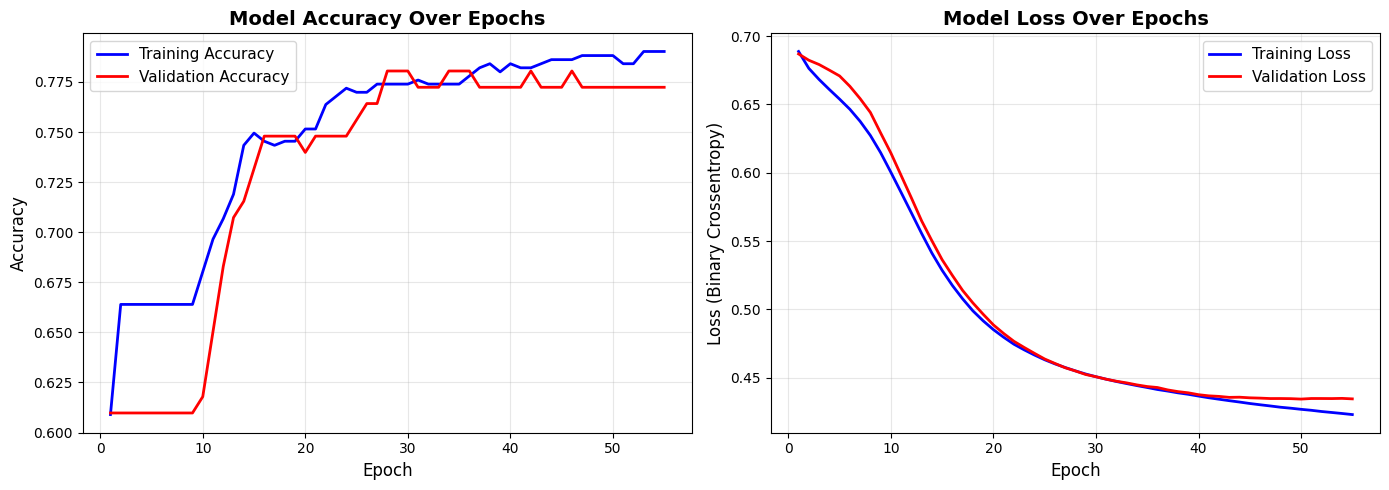

✓ Training visualization complete!


In [71]:
# Extract history data
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
accuracy_values = history.history['binary_accuracy']
val_accuracy_values = history.history['val_binary_accuracy']

epochs = range(1, len(loss_values) + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy
ax1.plot(epochs, accuracy_values, 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epochs, val_accuracy_values, 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
# ax1.set_ylim([0.8, 1.0])  # Removed: was hiding validation accuracy below 0.8

# Plot 2: Loss
ax2.plot(epochs, loss_values, 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs, val_loss_values, 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss (Binary Crossentropy)', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()

os.makedirs('results', exist_ok=True)
plt.savefig('results/training_curves.png', dpi=150, bbox_inches='tight')
print("✓ Saved: results/training_curves.png")

plt.show()
print("✓ Training visualization complete!")

# Model Evaluation

In [61]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("=" * 70)
print("MODEL EVALUATION ON TEST DATA")
print("=" * 70)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n✓ Model successfully evaluated on unseen test data!")

MODEL EVALUATION ON TEST DATA

Test Loss: 0.4834
Test Accuracy: 0.7662 (76.62%)

✓ Model successfully evaluated on unseen test data!


✓ Saved: results/confusion_matrix.png


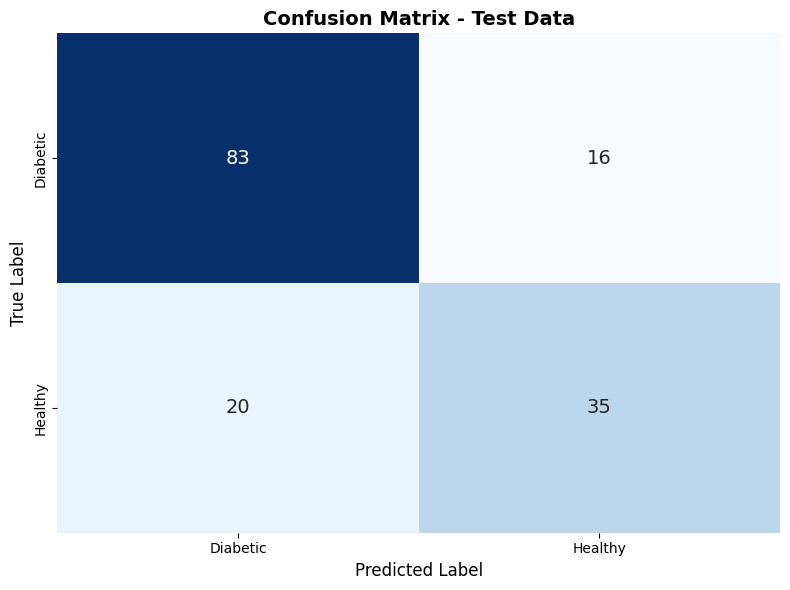


Confusion Matrix:
  True Negatives (TN):  83  (Correctly identified diabetic)
  True Positives (TP):  35  (Correctly identified healthy)
  False Positives (FP): 16  (Incorrectly labeled healthy)
  False Negatives (FN): 20  (Incorrectly labeled diabetic)


In [72]:
# Make predictions on test data
y_pred_prob = model.predict(X_test, verbose=0)  # Get probabilities
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert to class labels (0 or 1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Diabetic', 'Healthy'],
            yticklabels=['Diabetic', 'Healthy'],
            annot_kws={'size': 14})
plt.title('Confusion Matrix - Test Data', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

os.makedirs('results', exist_ok=True)
plt.savefig('results/confusion_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Saved: results/confusion_matrix.png")

plt.show()


print("\nConfusion Matrix:")
print(f"  True Negatives (TN):  {cm[0, 0]}  (Correctly identified diabetic)")
print(f"  True Positives (TP):  {cm[1, 1]}  (Correctly identified healthy)")
print(f"  False Positives (FP): {cm[0, 1]}  (Incorrectly labeled healthy)")
print(f"  False Negatives (FN): {cm[1, 0]}  (Incorrectly labeled diabetic)")

In [67]:
# Calculate additional metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate metrics for each class
precision_malignant = precision_score(y_test, y_pred, pos_label=0)
recall_malignant = recall_score(y_test, y_pred, pos_label=0)

print("=" * 70)
print("DETAILED CLASSIFICATION METRICS")
print("=" * 70)

print(f"\nOverall Metrics:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {precision:.4f} (of predicted healthy, {precision*100:.2f}% are correct)")
print(f"  Recall:    {recall:.4f} (we catch {recall*100:.2f}% of actual healthy cases)")
print(f"  F1-Score:  {f1:.4f} (harmonic mean)")

print(f"\nDiabetic (Class 1) Identification:")
print(f"  Recall:    {recall_malignant:.4f} (catch {recall_malignant*100:.2f}% of Diabetic cases)")
print(f"  Precision: {precision_malignant:.4f}")

print(f"\n📊 Medical Interpretation:")
print(f"  • False Negatives: {cm[1, 0]} cases (healthy predicted but actually diabetic) ⚠️")
print(f"  • False Positives: {cm[0, 1]} cases (diabetic predicted but actually healthy)")
print(f"  • For medical diagnosis: Recall (catching diabetic) is critical!")

DETAILED CLASSIFICATION METRICS

Overall Metrics:
  Accuracy:  0.7662
  Precision: 0.6863 (of predicted healthy, 68.63% are correct)
  Recall:    0.6364 (we catch 63.64% of actual healthy cases)
  F1-Score:  0.6604 (harmonic mean)

Diabetic (Class 1) Identification:
  Recall:    0.8384 (catch 83.84% of Diabetic cases)
  Precision: 0.8058

📊 Medical Interpretation:
  • False Negatives: 20 cases (healthy predicted but actually diabetic) ⚠️
  • False Positives: 16 cases (diabetic predicted but actually healthy)
  • For medical diagnosis: Recall (catching diabetic) is critical!


# Making metrics_summary.txt

In [75]:

# Save metrics summary to results/metrics_summary.txt
os.makedirs('results', exist_ok=True)

metrics_text = f"""PIMA INDIANS DIABETES - NEURAL NETWORK RESULTS
================================================

Dataset      : Pima Indians Diabetes (768 samples, 8 features)
Model        : Input(8) → Dense(32,ReLU) → Dense(16,ReLU) → Dense(8,ReLU) → Output(1,Sigmoid)
Optimizer    : Adam (lr=0.001)
Loss         : Binary Crossentropy
Scaler       : MinMaxScaler
Train/Test   : 80% / 20%

PERFORMANCE METRICS
-------------------
Test Accuracy  : {test_accuracy:.4f}  ({test_accuracy*100:.2f}%)
Test Loss      : {test_loss:.4f}
Precision      : {precision:.4f}
Recall         : {recall:.4f}
F1-Score       : {f1:.4f}

CONFUSION MATRIX
----------------
True  Negatives (TN): {cm[0, 0]}  (correctly classified as non-diabetic)
False Positives (FP): {cm[0, 1]}  (non-diabetic predicted as diabetic)
False Negatives (FN): {cm[1, 0]}  (diabetic predicted as non-diabetic)  ⚠️
True  Positives (TP): {cm[1, 1]}  (correctly classified as diabetic)
"""

with open('results/metrics_summary.txt', 'w', encoding='utf-8') as f:
    f.write(metrics_text)

print(metrics_text)
print("✓ Saved: results/metrics_summary.txt")


PIMA INDIANS DIABETES - NEURAL NETWORK RESULTS

Dataset      : Pima Indians Diabetes (768 samples, 8 features)
Model        : Input(8) → Dense(32,ReLU) → Dense(16,ReLU) → Dense(8,ReLU) → Output(1,Sigmoid)
Optimizer    : Adam (lr=0.001)
Loss         : Binary Crossentropy
Scaler       : MinMaxScaler
Train/Test   : 80% / 20%

PERFORMANCE METRICS
-------------------
Test Accuracy  : 0.7662  (76.62%)
Test Loss      : 0.4834
Precision      : 0.6863
Recall         : 0.6364
F1-Score       : 0.6604

CONFUSION MATRIX
----------------
True  Negatives (TN): 83  (correctly classified as non-diabetic)
False Positives (FP): 16  (non-diabetic predicted as diabetic)
False Negatives (FN): 20  (diabetic predicted as non-diabetic)  ⚠️
True  Positives (TP): 35  (correctly classified as diabetic)

✓ Saved: results/metrics_summary.txt
